In [1]:
import enum
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.cm import ScalarMappable
import eurostat

# Add the root dir to the path, so we can load the module.
sys.path.append(os.path.abspath(".."))

from data_analysis.eurostat_population_utils import get_eurostat_population_data 
from data_analysis.eurostat_crf_utils import *
from data_analysis.eurostat_geo import *

In [2]:
# Year we want to visualize
YEAR = 2016

In [3]:
# fetch emission data using 'get_eurostat_crf_data_for_code' function
df_emis = get_eurostat_crf_data_for_code(
    "TOTX4_MEMONIA", YEAR).rename(columns={'value': 'MtCO2eq'})

In [4]:
# fetch demographic data using 'get_eurostat_population_data' function
df_demo = get_eurostat_population_data(
    YEAR).rename(columns={'value': 'population'})

In [5]:
# Merge the data frames on select only EU27 countries.
df = df_emis.merge(df_demo, on='geo')
df = df.loc[df.index.isin([geo.value for geo in eu27_geo_dict.keys()])]
df['country'] = eu27_geo_dict.values()

In [6]:
df['population_(mil)'] = (df['population'] / 1000000)
df['em_per_capita'] = (df['MtCO2eq'] * 1000000) / df['population']
df['total'] = (df['population_(mil)'] * df['em_per_capita'])

In [7]:
df.head()

,MtCO2eq,population,country,population_(mil),em_per_capita,total
geo,,,,,,
AT,82.16347,8700471.0,Rakousko,8.700471,9.443566,82.16347
BE,121.82931,11311117.0,Belgie,11.311117,10.770759,121.82931
BG,58.48840,7153784.0,Bulharsko,7.153784,8.175869,58.48840
CY,9.74565,848319.0,Kypr,0.848319,11.488190,9.74565
CZ,131.84903,10553843.0,Česko,10.553843,12.492988,131.84903


TOHLE TVOŘÍM: https://faktaoklimatu.cz/infografiky/emise-eu-na-osobu

Potřebuju aby graf:
- na ose Y ukazoval emise na obyvatele ("em_per_capita")
- na ose x bude zobrazena populace (population_(mil))
- na ose X budou státy řazeny podle hodnoty emisí na obyvatele ("em_per_capita"), tedy podle osy Y
--- mezi jednotlivými státy bude pevně daná mezera
- plocha sloupce ukazovala součin populace státu a celkových ročních emisí ("total")
- sloupce budou různě barevné podle škály (viz původní graf)


### TODO
- uprav pozice tak, aby před prvním barem nebyla mezera
-- tohle furt nevim jak udělat

## Verze 30.1. 

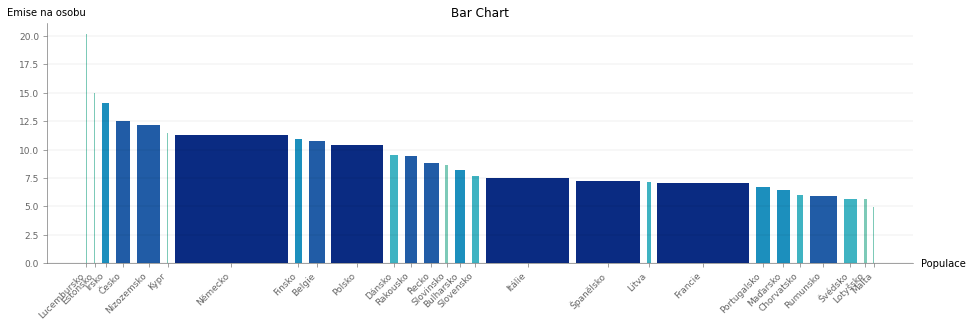

In [8]:
# You can change the color groups in the chart by changing 'intervals' here
color_intervals = [20, 40, 60, 83]

# Sort the DataFrame based on the 'em_per_capita' column in descending order
df_sorted = df.sort_values(by='em_per_capita', ascending = False)

# Calculate the widths for each bar based on the sorted total values
widths_2 = df_sorted['population_(mil)'].values.tolist()

# COMPUTE POSITIONS ON X AX
# Set the gap between bars
gap_2 = 5
# Each position is the previous one + half of the widths of the neighbouring columns + the gap
positions_2 = [widths_2[0]/2 + gap_2]
for i in range(len(widths_2) - 1):
    positions_2.append(positions_2[i] + widths_2[i]/2 + widths_2[i+1]/2 + gap_2)
# Find the minimum value in the list
min_value = min(positions_2)
# Subtract the minimum value from each element in the list
positions_2 = [value - min_value for value in positions_2]

# CREATE COLOR INTERVALS
# Choose colors       
colors = ['#3fb3c2', '#1c8fbd', '#215ca6', '#0a2b82', '#7dcab8']

# Create df_sorted_total which is sorted by 'total' values to correctly add the colors
df_sorted_total = df.sort_values(by='total', ascending = False)

# Determine the color for each 'total' value
color_mapping = np.digitize(df_sorted_total['total'], bins=np.percentile(df_sorted_total['total'], color_intervals))

# Create a DataFrame
df_for_colors = pd.DataFrame({'total': df_sorted_total['total'], 'colors': [colors[i-1] for i in color_mapping]}) 
df_sorted['colors'] = df_for_colors['colors']   
        
# SET CHART PROPRETIES 
# Set the size of the chart frame
plt.figure(figsize=(14,4))

# Create a bar chart with sorted, spaced, and no overlap bars
bars_2 = plt.bar(positions_2, df_sorted['em_per_capita'], width=widths_2, color=df_sorted['colors'], edgecolor=None)

# Adding labels and title
plt.xlabel('Populace')
plt.ylabel('Emise na osobu', rotation=0)
plt.title('Bar Chart')

# Set x-axis ticks to the positions of the bars
plt.xticks(positions_2, df_sorted['country'], rotation=45, ha='right')  

# Remove vertical grid lines
plt.gca().xaxis.grid(False)

# Move ax x label
plt.gca().xaxis.set_label_coords(1.035, 0.02)
plt.gca().yaxis.set_label_coords(0.0, 1.02)

# DISPLAY THE CHART
plt.show()

# TESTOVACÍ - irelevantní pro Honzu

## Verze - intervaly podle dělení 'total' hodnot na 5 sekcí 

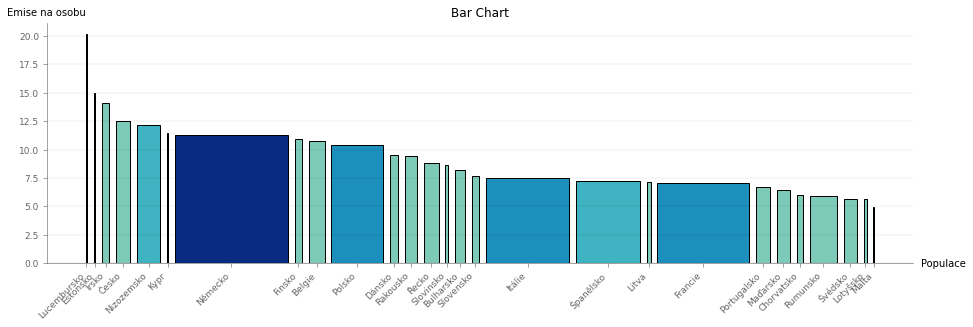

In [9]:
# Sort the DataFrame based on the 'em_per_capita' column in descending order
df_sorted = df.sort_values(by='em_per_capita', ascending = False)

# Calculate the widths for each bar based on the sorted total values
widths_2 = df_sorted['population_(mil)'].values.tolist()

# Set the gap between bars
gap_2 = 5

# Compute the bar position on x ax
# Each position is the previous one + half of the widths of the neighbouring columns + the gap
positions_2 = [widths_2[0]/2 + gap_2]
for i in range(len(widths_2) - 1):
    positions_2.append(positions_2[i] + widths_2[i]/2 + widths_2[i+1]/2 + gap_2)
# Find the minimum value in the list
min_value = min(positions_2)
# Subtract the minimum value from each element in the list
positions_2 = [value - min_value for value in positions_2]
    
# CREATE COLOR INTERVALS
# Given values
min_value = 2
max_value = 935

# Find the range
value_range = max_value - min_value

# Calculate interval size
interval_size = round(value_range / 5)

# Calculate intervals
interval_1 = [min_value, min_value + interval_size]
interval_2 = [interval_1[1]+1, interval_1[1] + interval_size]
interval_3 = [interval_2[1]+1, interval_2[1] + interval_size]
interval_4 = [interval_3[1]+1, interval_3[1] + interval_size]
interval_5 = [interval_4[1]+1, interval_4[1] + interval_size]

# Assign colors to values based on intervals
colors = []
for value in df_sorted['total']:
    if interval_5[0] <= value <= interval_5[1]:
        colors.append('#0a2b82')  # Color for interval_5
    elif interval_4[0] <= value <= interval_4[1]:
        colors.append('#215ca6')  # Color for interval_4
    elif interval_3[0] <= value <= interval_3[1]:
        colors.append('#1c8fbd')  # Color for interval_3
    elif interval_2[0] <= value <= interval_2[1]:
        colors.append('#3fb3c2')  # Color for interval_2
    elif interval_1[0] <= value <= interval_1[1]:
        colors.append('#7dcab8')  # Color for interval_1

# Add the 'colors' column to the DataFrame
df_sorted['colors'] = colors
    
# Set the size of the chart frame
plt.figure(figsize=(14,4))

# Create a bar chart with sorted, spaced, and no overlap bars
bars_2 = plt.bar(positions_2, df_sorted['em_per_capita'], width=widths_2, color=colors, edgecolor='black')

# Adding labels and title
plt.xlabel('Populace')
plt.ylabel('Emise na osobu', rotation=0)
plt.title('Bar Chart')

# Set x-axis ticks to the positions of the bars
plt.xticks(positions_2, df_sorted['country'], rotation=45, ha='right')  

# Remove vertical grid lines
plt.gca().xaxis.grid(False)

# Move ax x label
plt.gca().xaxis.set_label_coords(1.035, 0.02)
plt.gca().yaxis.set_label_coords(0.0, 1.02)

# Display the plot
plt.show()

## Color intervals 

- barvy vypipetovány z grafiky na webu
- intervaly převzaty z webu
- sloupce, které intervaly nepokrývají, zobrazeny červeně 

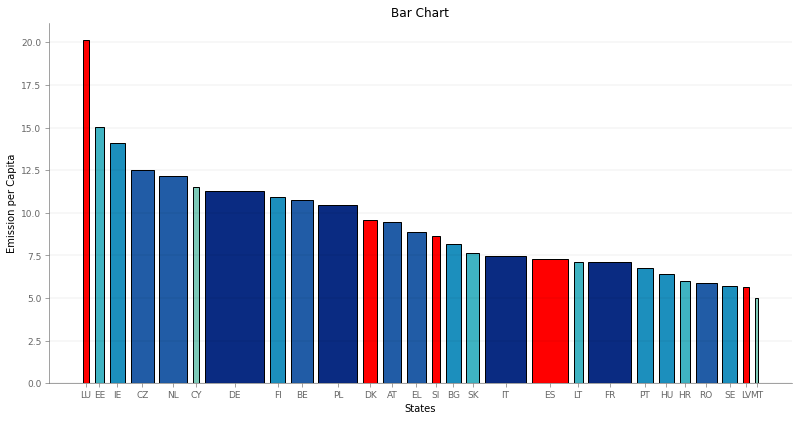

In [10]:
# Sort the DataFrame based on the 'em_per_capita' column in descending order
df_sorted = df.sort_values(by='em_per_capita', ascending = False)

# Calculate the widths for each bar based on the sorted total values
widths_2 = np.sqrt(df_sorted['total'].values.tolist())

# Set the gap between bars
gap_2 = 3

# Compute the bar position on x ax
# Each position is the previous one + half of the widths of the neighbouring columns + the gap
positions_2 = [widths_2[0]/2 + gap_2]
for i in range(len(widths_2) - 1):
    positions_2.append(positions_2[i] + widths_2[i]/2 + widths_2[i+1]/2 + gap_2)

# Color intervals
interval_1 = [340, 935]
interval_2 = [82, 207]
interval_3 = [55, 71]
interval_4 = [19, 53]
interval_5 = [2, 11]

# Assign colors to values based on intervals
colors = []
for value in df_sorted['total']:
    if interval_1[0] <= value <= interval_1[1]:
        colors.append('#0a2b82')  # Color for interval_1
    elif interval_2[0] <= value <= interval_2[1]:
        colors.append('#215ca6')  # Color for interval_2
    elif interval_3[0] <= value <= interval_3[1]:
        colors.append('#1c8fbd')  # Color for interval_3
    elif interval_4[0] <= value <= interval_4[1]:
        colors.append('#3fb3c2')  # Color for interval_4
    elif interval_5[0] <= value <= interval_5[1]:
        colors.append('#7dcab8')  # Color for interval_5
    else:
        colors.append('red')  # Default color for other values

# Add the 'colors' column to the DataFrame
df_sorted['colors'] = colors
    
# Set the size of the chart frame
plt.figure(figsize=(12,6))

# Create a bar chart with sorted, spaced, and no overlap bars
bars_2 = plt.bar(positions_2, df_sorted['em_per_capita'], width=widths_2, color=colors, edgecolor='black')

# Adding labels and title
plt.xlabel('States')
plt.ylabel('Emission per Capita')
plt.title('Bar Chart')

# Set x-axis ticks to the positions of the bars
plt.xticks(positions_2, df_sorted.index)

# Remove vertical grid lines
plt.gca().xaxis.grid(False)

# Display the plot
plt.show()

## Color scale 

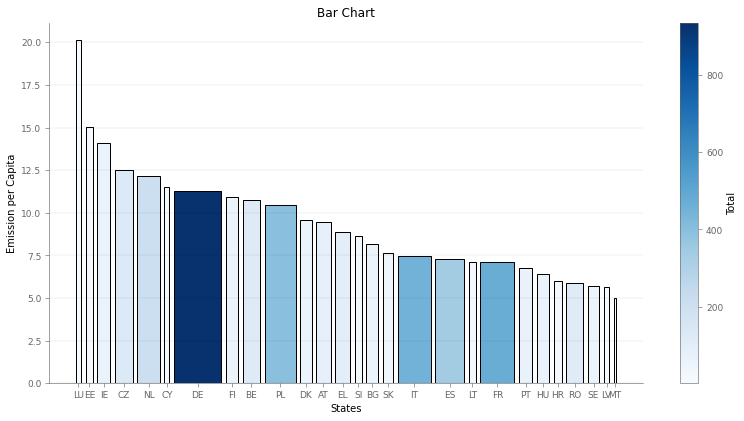

In [11]:
# Sort the DataFrame based on the 'em_per_capita' column in descending order
df_sorted = df.sort_values(by='em_per_capita', ascending = False)

# Calculate the widths for each bar based on the sorted total values
widths_2 = np.sqrt(df_sorted['total'].values.tolist())

# Set the gap between bars
gap_2 = 3

# Compute the bar position on x ax
# Each position is the previous one + half of the widths of the neighbouring columns + the gap
positions_2 = [widths_2[0]/2 + gap_2]
for i in range(len(widths_2) - 1):
    positions_2.append(positions_2[i] + widths_2[i]/2 + widths_2[i+1]/2 + gap_2)

# Create a ScalarMappable to map total values to colors
norm = plt.Normalize(2, 935)
colors = plt.cm.Blues(norm(df_sorted['total']))

# Set the size of the chart frame
plt.figure(figsize=(12,6))

# Create a bar chart with sorted, spaced, and no overlap bars
bars_2 = plt.bar(positions_2, df_sorted['em_per_capita'], width=widths_2, color=colors, edgecolor='black')

# Adding labels and title
plt.xlabel('States')
plt.ylabel('Emission per Capita')
plt.title('Bar Chart')

# Set x-axis ticks to the positions of the bars
plt.xticks(positions_2, df_sorted.index)

# Remove vertical grid lines
plt.gca().xaxis.grid(False)

# Create a ScalarMappable to create a colorbar
sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
sm.set_array([])  # Optional, but avoids a warning

# Display the colorbar
cbar = plt.colorbar(sm, orientation='vertical')
cbar.set_label('Total')

# Display the plot
plt.show()

verze kam se chci dostat:
https://faktaoklimatu.cz/infografiky/emise-eu-na-osobu

## Treninková data - test

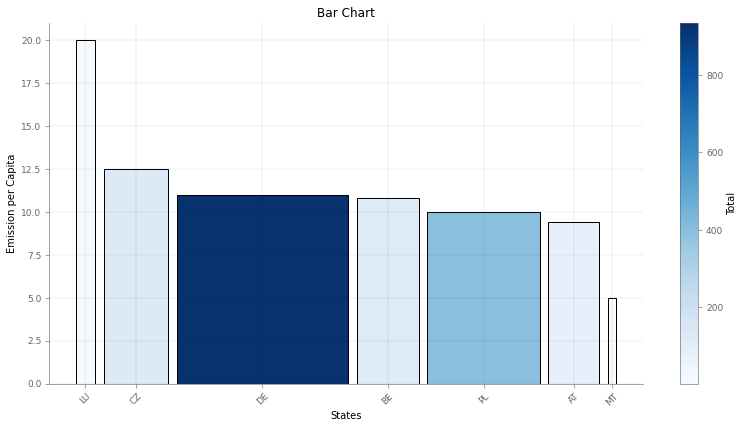

In [12]:
# Sample data in a DataFrame
my_data = pd.DataFrame({
    'States': ['AT', 'BE', 'CZ', 'DE', 'LU', 'PL','MT'],
    'population': [8.7, 11.3, 10.5, 82, 0.58, 38, 0.45],
    'em_per_capita': [9.4, 10.8, 12.5, 11, 20, 10, 4.98],
    'total': [82, 121.8, 131, 925, 11.6, 397, 2.2]
})

# Sort the DataFrame based on the 'em_per_capita' column in descending order
sorted_data = my_data.sort_values(by='em_per_capita', ascending=False)

# Calculate the widths for each bar based on the sorted total values
widths = np.sqrt(sorted_data['total'].values.tolist())

# Set the gap between bars
gap = 1.5  

# Each position is the previous one + half of the widths of the neighbouring columns + the gap
positions = [widths[0]/2 + gap]
for i in range(len(widths) - 1):
    positions.append(positions[i] + widths[i]/2 + widths[i+1]/2 + gap)

# Create a ScalarMappable to map total values to colors
norm = plt.Normalize(2, 935)
colors = plt.cm.Blues(norm(sorted_data['total']))

# Set the size of the chart frame
plt.figure(figsize=(12,6))

# Create a bar chart with sorted, spaced, and no overlap bars
bars = plt.bar(positions, sorted_data['em_per_capita'], width=widths, color=colors, edgecolor='black')

# Adding labels and title
plt.xlabel('States')
plt.ylabel('Emission per Capita')
plt.title('Bar Chart')

# Set x-axis ticks to the positions of the bars
plt.xticks(positions, sorted_data['States'], rotation=45)

# Create a ScalarMappable to create a colorbar
sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
sm.set_array([])  # Optional, but avoids a warning

# Display the colorbar
cbar = plt.colorbar(sm, orientation='vertical')
cbar.set_label('Total')

# Display the plot
plt.show()